<a href="https://colab.research.google.com/github/Teacher-Heiko/fastbook/blob/master/MaxPool_Dropout_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np



In [2]:
# Download and prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 57196545.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105427061.64it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19388102.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19242958.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
from fastai.vision.all import *

path = untar_data(URLs.MNIST)

In [4]:
Path.BASE_PATH = path

def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

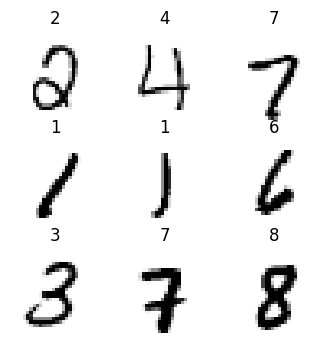

In [5]:
dls.show_batch(max_n=9, figsize=(4,4))

In [6]:
def simple_cnn():
   return nn.Sequential(
      nn.Conv2d(1, 4, kernel_size=(3,3), stride=1, padding=1), # Output Size: [4, 28, 28] (4 channels, 28x28 pixels)
      nn.ReLU(),

      nn.Conv2d(4, 8, kernel_size=(3,3), stride=1, padding=1), # [8, 28, 28] (8 channels, 28x28 pixels)
      nn.ReLU(),

      nn.Flatten(),
      nn.Linear(8*28*28, 64),
      nn.Linear(64, 10)
   )

In [7]:
simple_cnn()

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=64, bias=True)
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.6)
    return learn

In [9]:
 learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


SuggestedLRs(valley=0.0012022644514217973)

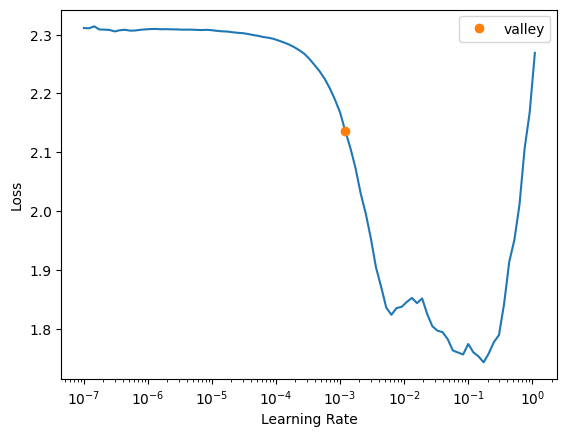

In [10]:
learn.lr_find()

In [11]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.343648,2.342269,0.113500,01:17


<figure>
<!-- <img src="./images/2-convmodel-2.png" width="250" alt="Diagram of a convolutional model."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Vko6nCK.png" width="250" alt="Diagram of a convolutional model.">
</figure>

In [12]:
def simple_cnn_max():
   return nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=(3,3), stride=1, padding=1), # Output Size: [8, 28, 28]
      nn.ReLU(),
      nn.MaxPool2d(2),                                         # Output Size: [8, 14, 14] (4 channels, 14x14 pixels)

      nn.Conv2d(8, 32, kernel_size=(3,3), stride=1, padding=1), # [32, 14, 14] (8 channels, 14x14 pixels)
      nn.ReLU(),

      nn.Flatten(),
      nn.Linear(32*14*14, 32*16), # out 512
      #Dropout
      nn.Linear(32*16, 64),
      #Dropout
      nn.Linear(64, 10)
   )

simple_cnn_max()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=6272, out_features=512, bias=True)
  (7): Linear(in_features=512, out_features=64, bias=True)
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
def fit_max(epochs=1):
    learn = Learner(dls, simple_cnn_max(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [14]:
learn_max = fit_max()

epoch,train_loss,valid_loss,accuracy,time
0,2.331716,2.324155,0.097400,01:19
